In [1]:
import os
import itertools
import sys
import numpy as np
import pickle
from scipy.io.matlab import loadmat
from sklearn.metrics import mean_squared_error, roc_auc_score
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle

from almc.bayesian_rescal import PFBayesianRescal
from almc.bayesian_rescal import PFBayesianCompRescal
from almc.bayesian_rescal import PFBayesianLogitRescal

%matplotlib inline

In [2]:
def load_dataset(dataset):
    if dataset == 'umls':
        mat = loadmat('../data/%s/uml.mat' % (dataset))
        T = np.array(mat['Rs'], np.float32)
    elif dataset == 'nation':
        mat = loadmat('../data/%s/dnations.mat' % (dataset))
        T = np.array(mat['R'], np.float32)
    elif dataset == 'kinship':
        mat = loadmat('../data/%s/alyawarradata.mat' % (dataset))
        T = np.array(mat['Rs'], np.float32)
    elif dataset == 'wordnet':
        T = pickle.load(open('../data/%s/reduced_wordnet.pkl' % (dataset), 'rb'))
    elif dataset == 'freebase':
        T, _, _ = pickle.load(open('../data/freebase/subset_5000.pkl', 'rb'))

    if dataset == 'umls' or dataset == 'nation' or dataset == 'kinship':
        T = np.swapaxes(T, 1, 2)
        T = np.swapaxes(T, 0, 1)  # [relation, entity, entity]
        T[np.isnan(T)] = 0
    return T

def plot_result(result, ps, models, width = 0.006):
    plt.figure()
    fig, ax = plt.subplots(figsize=(12,8))
    for model in models:
        mean = np.zeros(len(ps))
        std = np.zeros(len(ps))
        for i, p in enumerate(ps):
            mean[i] = np.mean(result[(model,p)])
            std[i] = np.std(result[(model,p)])
        ax.bar(ps + width*models.index(model), mean, width, color=color[models.index(model)], yerr=std, label=model)
    ax.set_xticks(ps+width*2)
    ax.set_xticklabels(['%.2f'% (p) for p in ps])
    ax.legend(loc='upper left')
    plt.show()

In [3]:
color = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(color)):    
    r, g, b = color[i]    
    color[i] = (r / 255., g / 255., b / 255.)
    
model_colors = {'brescal':color[0], 'amdc_pop':color[8], 'amdc_pred':color[7], 
                'bcomp_mul':color[2], 'bcomp_add':color[3], 'logit':color[5], 
                'rescal':'grey',
                'brescal_passive':'grey', 'bcomp_mul_10': color[8], 'bcomp_add_10':color[9], 
                'bcomp_mul_comp_10':color[11], 'bcomp_add_comp_10':color[13], 
                'bcomp_mul_var_1_comp_10': color[15], 'bcomp_add_var_1_comp_10': color[17]}
model_names = {'rescal':'rescal', 'brescal':'pnormal', 'amdc_pop':'amdc_pop', 'amdc_pred':'amdc_pred', 
               'bcomp_mul':'pcomp-mul', 'bcomp_add':'pcomp-add', 'logit':'plogit', 
               'brescal_passive':'brescal_passive'}    

# ps = np.linspace(0.05, 0.3, 6)

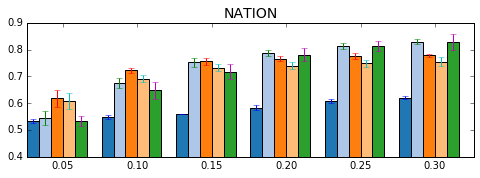

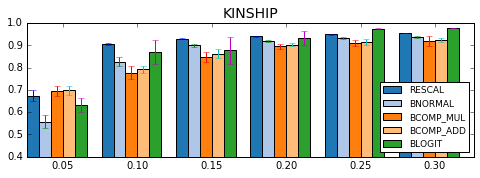

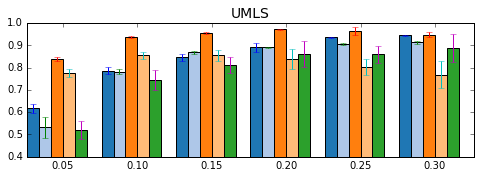

In [6]:
var_comps = dict()
var_comps['nation'] = 10
var_comps['kinship'] = 100
var_comps['umls'] = 1
var_x = 0.1
    
datasets = ['nation', 'kinship', 'umls']
models = ['rescal', 'brescal', 'bcomp_mul', 'bcomp_add', 'logit']


for dataset in datasets:
    ps = np.linspace(0.05, 0.3, 6)
    n_dim = 10
    n_particle = 1

    n_test = 10
    max_iter = 1

    title_size = 14
    label_size = 12
    legend_size=9

    width = 0.16
    result = pickle.load(open('../result/%s/training_error_10.pkl' % dataset, 'rb'))
    rescal_result =  pickle.load(open('../result/%s/rescal_training_error_10.pkl' % dataset, 'rb'))

    var_comp = var_comps[dataset]

    plt.figure(figsize=(8,2.4))

    for model in models:
        mean = np.zeros(len(ps))
        std = np.zeros(len(ps))
        for i, p in enumerate(ps):
            if model=='rescal':
                mean[i] = np.mean(rescal_result[(model, p)])
                std[i] = np.std(rescal_result[(model, p)])
            else:            
                mean[i] = np.mean(result[(model, p, var_comp)])
                std[i] = np.std(result[(model, p, var_comp)])
        model_name = model

        color = model_colors[model]
        model_name = model_names[model].upper()
        plt.bar(np.arange(len(ps)) + width*models.index(model), mean, width, color=color, yerr=std, label=model_name)

    plt.xticks(np.arange(len(ps)) + width*3, ['%.2f'% (p) for p in ps])
    plt.title(dataset.upper(), size=title_size)
    if dataset == 'nation':
        plt.ylim((0.4, 0.9))
    else:
        plt.ylim((0.4, 1))     
    if dataset == 'kinship':
        plt.legend(loc='lower right', prop={'size':legend_size})
    plt.savefig('../paper/images/comp_training_error_%s.pdf' % (dataset), format='PDF', bbox_inches='tight', pad_inches=0.1)

# ps = np.linspace(0.01, 0.14, 14)

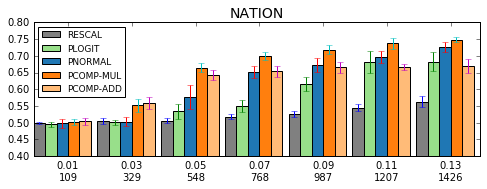

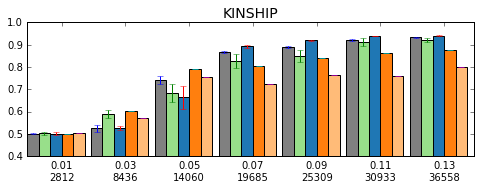

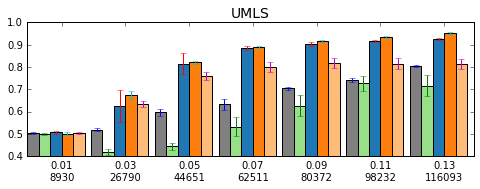

In [4]:
var_comps = dict()
var_comps['nation'] = 1
var_comps['kinship'] = 100
var_comps['umls'] = 1

datasets = ['nation', 'kinship', 'umls']
models = ['rescal', 'logit', 'brescal', 'bcomp_mul', 'bcomp_add']
ps = np.linspace(0.01, 0.14, 14)
ps = ps[::2]

total_triple = {'kinship':281216,
               'umls':893025,
               'nation':10976}

for dataset in datasets:
    n_dim = 10
    n_particle = 1
    n_test = 10
    max_iter = 1

    title_size = 14
    label_size = 12
    legend_size=9

    width = 0.18
    if dataset == 'umls':
        comp_result = pickle.load(open('../result/%s/frontal_training_error_10_0.10.pkl' % dataset, 'rb'))
    result = pickle.load(open('../result/%s/frontal_training_error_10.pkl' % dataset, 'rb'))
    rescal_result =  pickle.load(open('../result/%s/rescal_frontal_training_error_10.pkl' % dataset, 'rb'))
    if dataset=='kinship':
        result = pickle.load(open('../result/%s/frontal_training_error_10_0.00_without_identity.pkl' % dataset, 'rb'))
        rescal_result =  pickle.load(open('../result/%s/rescal_frontal_training_error_10_without_identity.pkl' % dataset, 'rb'))
        comp_result = pickle.load(open('../result/%s/frontal_training_error_10_without_identity_comp.pkl' % dataset, 'rb'))

    plt.figure(figsize=(8,2.4))

    for model in models:
        var_comp = var_comps[dataset]
        mean = np.zeros(len(ps))
        std = np.zeros(len(ps))
        for i, p in enumerate(ps):
            if model=='rescal':
                mean[i] = np.mean(rescal_result[(model, p)])
                std[i] = np.std(rescal_result[(model, p)])
            elif (model=='bcomp_mul' or model=='bcomp_add') and (dataset=='umls'):
                mean[i] = np.mean(comp_result[(model, p, var_comp)])
                std[i] = np.std(comp_result[(model, p, var_comp)])
            elif (model=='bcomp_mul' or model=='bcomp_add') and (dataset=='kinship'):
                var_x = 0.01
                var_comp=1
                mean[i] = np.mean(comp_result[(model, p, var_x, var_comp)])
                std[i] = np.std(comp_result[(model, p, var_x, var_comp)])                
            else:
                mean[i] = np.mean(result[(model, p, var_comp)])
                std[i] = np.std(result[(model, p, var_comp)])
                
        color = model_colors[model]
        model_name = model_names[model].upper()
        plt.bar(np.arange(len(ps)) + width*models.index(model), mean, width, color=color, yerr=std, label=model_name)

    plt.xticks(np.arange(len(ps)) + width*3, ['%.2f\n%d'% (p, p*total_triple[dataset]) for p in ps])
    plt.title(dataset.upper(), size=title_size)
    if dataset == 'nation':
        plt.ylim((0.4, 0.8))
        plt.legend(loc='upper left', prop={'size':legend_size})
    else:
        plt.ylim((0.4, 1))
    plt.savefig('../paper/cikm2016/images/comp_training_error_%s_small.pdf' % (dataset), format='PDF', bbox_inches='tight', pad_inches=0.1)